In [1]:
import numpy as np
import torch
import cv2
from torch.nn.functional import interpolate
from kmeans_pytorch import kmeans
from sklearn.cluster import MeanShift
from PIL import Image

def preprocess(rgb, masks, patch_size=16):
    """预处理输入数据，调整RGB大小，生成二值mask"""
    masks = [masks == uid for uid in np.unique(masks) if uid != 0]  # 跳过背景ID 0

    H, W, _ = rgb.shape
    patch_h = H // patch_size
    patch_w = W // patch_size
    new_H, new_W = patch_h * patch_size, patch_w * patch_size

    transformed_rgb = cv2.resize(rgb, (new_W, new_H)).astype(np.float32) / 255.0

    shape_info = {
        'img_h': H,
        'img_w': W,
        'patch_h': patch_h,
        'patch_w': patch_w,
    }
    return transformed_rgb, rgb, masks, shape_info


@torch.inference_mode()
@torch.amp.autocast('cuda')
def get_features(dinov2, transformed_rgb, shape_info, device):
    img_h, img_w = shape_info['img_h'], shape_info['img_w']
    patch_h, patch_w = shape_info['patch_h'], shape_info['patch_w']

    img_tensors = torch.from_numpy(transformed_rgb).permute(2, 0, 1).unsqueeze(0).to(device)
    features_dict = dinov2.forward_features(img_tensors)
    raw_feature_grid = features_dict['x_norm_patchtokens']  # [1, patch_h*patch_w, C]
    raw_feature_grid = raw_feature_grid.reshape(1, patch_h, patch_w, -1)

    interpolated = interpolate(
        raw_feature_grid.permute(0, 3, 1, 2),
        size=(img_h, img_w),
        mode='bilinear'
    ).permute(0, 2, 3, 1).squeeze(0)

    features_flat = interpolated.reshape(-1, interpolated.shape[-1])
    return features_flat.reshape(img_h, img_w, -1)


def cluster_features(features, masks, config, device):
    """对mask区域特征聚类，获取候选点"""
    candidate_pixels, candidate_rigid_group_ids = [], []

    for rigid_group_id, binary_mask in enumerate(masks):
        if np.mean(binary_mask) > config['max_mask_ratio']:
            continue

        feature_pixels = np.argwhere(binary_mask)  # (y, x)
        obj_features = features[binary_mask]

        obj_features = obj_features.double()
        u, s, v = torch.pca_lowrank(obj_features, center=False)
        features_pca = torch.mm(obj_features, v[:, :3])

        features_pca = (features_pca - features_pca.min(0)[0]) / (
            features_pca.max(0)[0] - features_pca.min(0)[0]
        )

        feature_pixels_torch = torch.tensor(
            feature_pixels, dtype=features_pca.dtype, device=features_pca.device
        )
        feature_pixels_torch = (feature_pixels_torch - feature_pixels_torch.min(0)[0]) / (
            feature_pixels_torch.max(0)[0] - feature_pixels_torch.min(0)[0]
        )
        X = torch.cat([features_pca, feature_pixels_torch], dim=-1)

        cluster_ids, cluster_centers = kmeans(
            X=X,
            num_clusters=config['num_candidates_per_mask'],
            distance='euclidean',
            device=device,
        )
        cluster_centers = cluster_centers.to(device)

        for cluster_id in range(config['num_candidates_per_mask']):
            cluster_center = cluster_centers[cluster_id][:3]
            member_idx = cluster_ids == cluster_id
            member_pixels = feature_pixels[member_idx]
            member_features = features_pca[member_idx]

            dist = torch.norm(member_features - cluster_center, dim=-1)
            closest_idx = torch.argmin(dist)

            candidate_pixels.append(member_pixels[closest_idx])
            candidate_rigid_group_ids.append(rigid_group_id)

    return np.array(candidate_pixels), np.array(candidate_rigid_group_ids)


def merge_clusters(candidate_pixels, min_dist_bt_keypoints):
    """用MeanShift合并相近的候选点"""
    ms = MeanShift(bandwidth=min_dist_bt_keypoints, bin_seeding=True, n_jobs=32)
    ms.fit(candidate_pixels)
    cluster_centers = ms.cluster_centers_

    merged_indices = []
    for center in cluster_centers:
        dist = np.linalg.norm(candidate_pixels - center, axis=-1)
        merged_indices.append(np.argmin(dist))
    return merged_indices


def project_keypoints_to_img(rgb, candidate_pixels):
    """在图像上画关键点"""
    projected = rgb.copy()
    for idx, (y, x) in enumerate(candidate_pixels):
        text = str(idx)
        box_w, box_h = 30, 30
        cv2.rectangle(
            projected,
            (x - box_w // 2, y - box_h // 2),
            (x + box_w // 2, y + box_h // 2),
            (255, 255, 255), -1
        )
        cv2.rectangle(
            projected,
            (x - box_w // 2, y - box_h // 2),
            (x + box_w // 2, y + box_h // 2),
            (0, 0, 0), 2
        )
        org = (x - 7 * len(text), y + 7)
        cv2.putText(projected, text, org, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    return projected


def get_keypoints(rgb, masks, dinov2, config):
    device = torch.device(config['device'])

    transformed_rgb, rgb, masks, shape_info = preprocess(rgb, masks, patch_size=16)
    features = get_features(dinov2, transformed_rgb, shape_info, device)

    candidate_pixels, candidate_rigid_group_ids = cluster_features(
        features, masks, config, device
    )

    merged_indices = merge_clusters(candidate_pixels, config['min_dist_bt_keypoints'])
    candidate_pixels = candidate_pixels[merged_indices]
    candidate_rigid_group_ids = candidate_rigid_group_ids[merged_indices]

    sort_idx = np.lexsort((candidate_pixels[:, 0], candidate_pixels[:, 1]))
    candidate_pixels = candidate_pixels[sort_idx]
    candidate_rigid_group_ids = candidate_rigid_group_ids[sort_idx]

    projected = project_keypoints_to_img(rgb, candidate_pixels)
    return candidate_pixels, projected


In [2]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

def sam2_generate_mask(image_path, model_cfg, checkpoint, device="cuda"):
    """用SAM2生成整数mask (H, W)，每个区域对应一个ID"""
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    sam2 = build_sam2(model_cfg, checkpoint, device=torch.device(device), apply_postprocessing=False)
    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2,
        use_m2m=True,
        points_per_side=8,
        min_mask_region_area=300.0
        )

    anns = mask_generator.generate(image_np)

    # 转换为单通道整数mask
    h, w, _ = image_np.shape
    masks = np.zeros((h, w), dtype=np.int32)
    for idx, ann in enumerate(anns, start=1):
        m = ann["segmentation"]
        masks[m] = idx  # 每个mask区域赋一个唯一的ID

    return image_np, masks, anns

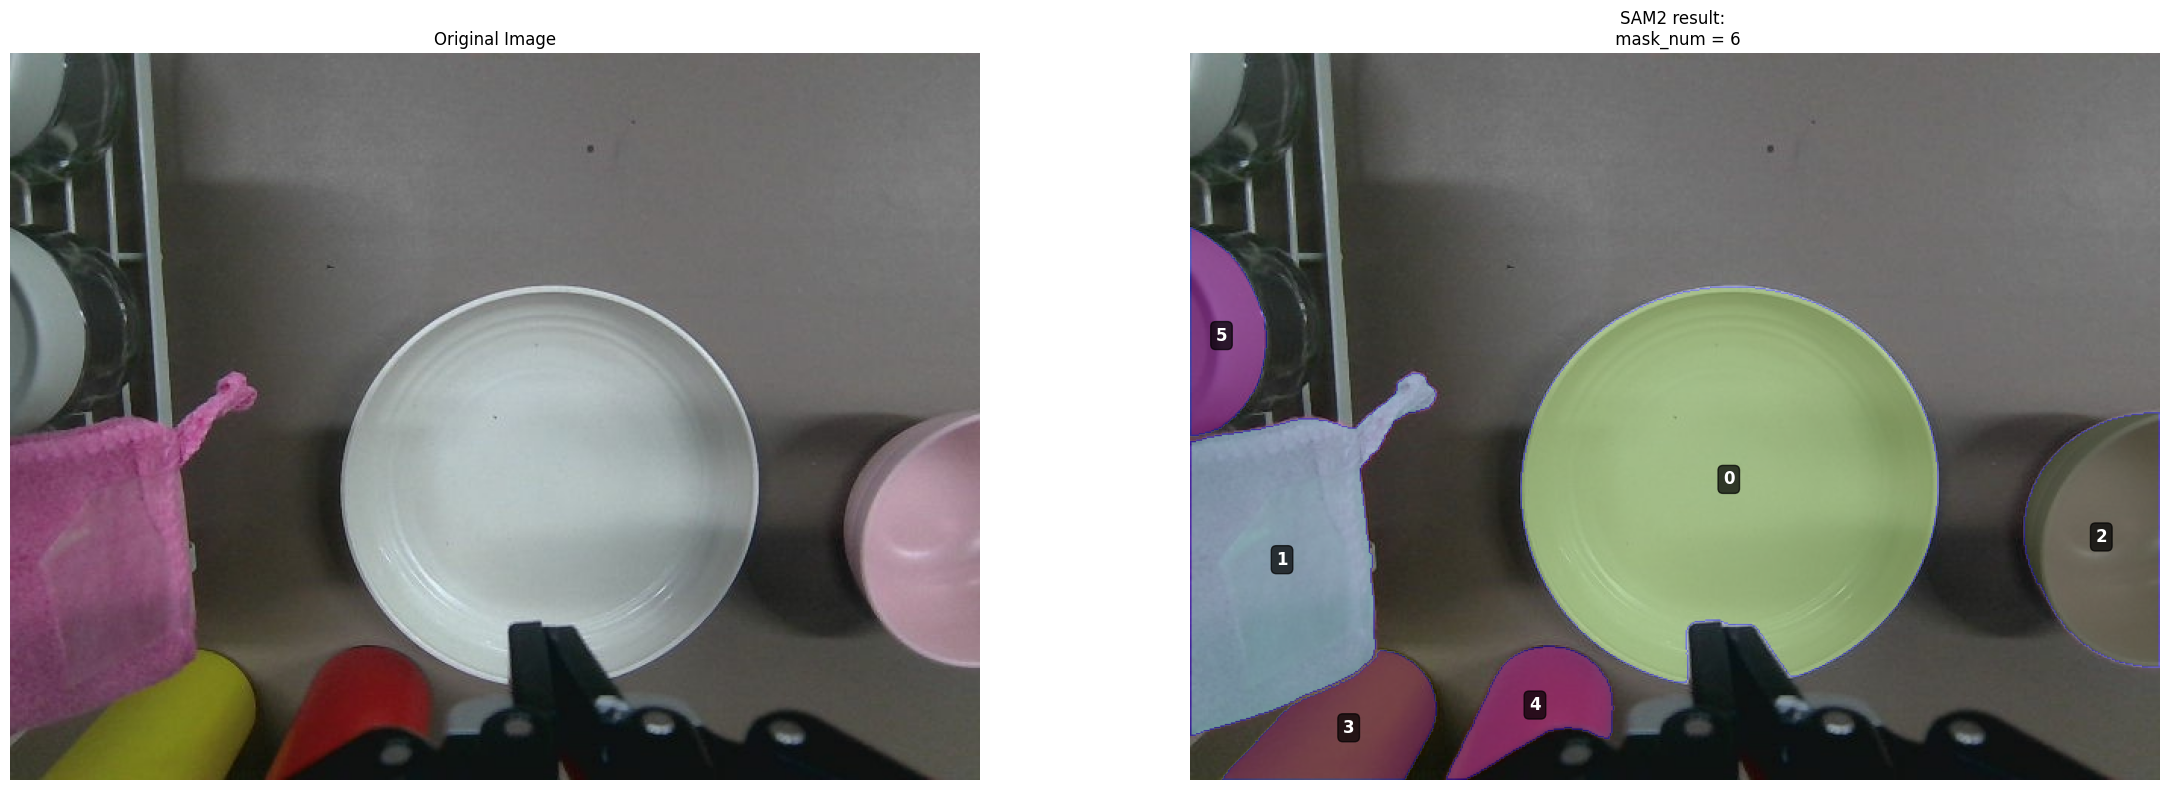

In [3]:
sam2_checkpoint = "./models/sam2/sam2_hiera_base_plus.pt"
model_cfg_0 = "configs/sam2/sam2_hiera_b+.yaml"

# sam2_checkpoint = "./models/sam2/sam2.1_hiera_base_plus.pt"
# model_cfg_0 = "configs/sam2.1/sam2.1_hiera_b+.yaml"
# 1. SAM2 生成 mask
rgb, masks, anns = sam2_generate_mask(
    "./img/test1.png",
    model_cfg=model_cfg_0,
    checkpoint=sam2_checkpoint,
    device="cuda"
)
import matplotlib.pyplot as plt

def show_anns(anns, borders=True, show_labels=True):
    """
    Args:
        anns: 掩码注释列表
        borders: 是否显示边界
        show_labels: 是否在掩码中心显示标号
    """
    if len(anns) == 0:
        return

    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0],
                sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0

    for idx, ann in enumerate(sorted_anns):
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask

        if borders:
            contours, _ = cv2.findContours(m.astype(np.uint8),
                                        cv2.RETR_EXTERNAL,
                                        cv2.CHAIN_APPROX_NONE)
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True)
                    for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

        # 在掩码中心添加标号
        if show_labels:
            # 计算掩码的中心点
            y_coords, x_coords = np.where(m)
            if len(y_coords) > 0 and len(x_coords) > 0:
                center_y = int(np.mean(y_coords))
                center_x = int(np.mean(x_coords))

                # 添加文本标号
                ax.text(center_x, center_y, str(idx),
                    fontsize=12, fontweight='bold',
                    color='white', ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.3',
                                facecolor='black', alpha=0.7))

    ax.imshow(img)

np.random.seed(3)
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# 原始图像
axes[0].imshow(rgb)
axes[0].set_title("Original Image")
axes[0].axis('off')

# SAM2 结果
np.random.seed(3)
axes[1].imshow(rgb)
plt.sca(axes[1])
show_anns(anns, borders=True)
axes[1].set_title(f"SAM2 result: \n mask_num = {len(anns)}")
axes[1].axis('off')


plt.tight_layout()
plt.show()


In [4]:
dinov2 = torch.hub.load('facebookresearch/dinov3', 'dinov3_vith16plus').eval().to('cuda')

config = {
    'device': 'cuda',
    'min_dist_bt_keypoints': 60,  # 最小点间距 像素级
    'seed': 0,
    'max_mask_ratio': 0.5,
    'num_candidates_per_mask': 5,
}

candidate_pixels, projected = get_keypoints(rgb, masks, dinov2, config)

print(candidate_pixels.shape)  # (N, 2)，像素坐标 (y, x)
cv2.imwrite("projected.png", projected[:, :, ::-1])


Using cache found in C:\Users\winco_ql5c0a5/.cache\torch\hub\facebookresearch_dinov3_main


running k-means on cuda..


[running kmeans]: 15it [00:00, 90.96it/s, center_shift=0.000070, iteration=15, tol=0.000100]


running k-means on cuda..


[running kmeans]: 11it [00:00, 305.37it/s, center_shift=0.000063, iteration=11, tol=0.000100]


running k-means on cuda..


[running kmeans]: 11it [00:00, 233.76it/s, center_shift=0.000071, iteration=11, tol=0.000100]


running k-means on cuda..


[running kmeans]: 22it [00:00, 340.40it/s, center_shift=0.000087, iteration=22, tol=0.000100]


running k-means on cuda..


[running kmeans]: 13it [00:00, 362.18it/s, center_shift=0.000069, iteration=13, tol=0.000100]


running k-means on cuda..


[running kmeans]: 13it [00:00, 250.98it/s, center_shift=0.000055, iteration=13, tol=0.000100]


(11, 2)


True